In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

import os

In [4]:
current_dir = os.getcwd()
code_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'codes'))
data_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'data'))

In [ ]:
# 读取图像
img = cv2.imread(os.path.join(data_path, 'test_RGB2.png'))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)




In [177]:
# # 转换为 HSV 色彩空间
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# v_channel = hsv[:, :, 2]  # 亮度通道

# # 中值滤波 + 自适应阈值（局部处理）
# v_blur = cv2.medianBlur(v_channel, 5)
# thresh = cv2.adaptiveThreshold(v_blur, 255, 
#                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                cv2.THRESH_BINARY_INV, 
#                                21, 10)

# # 可选：形态学操作清理小区域
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


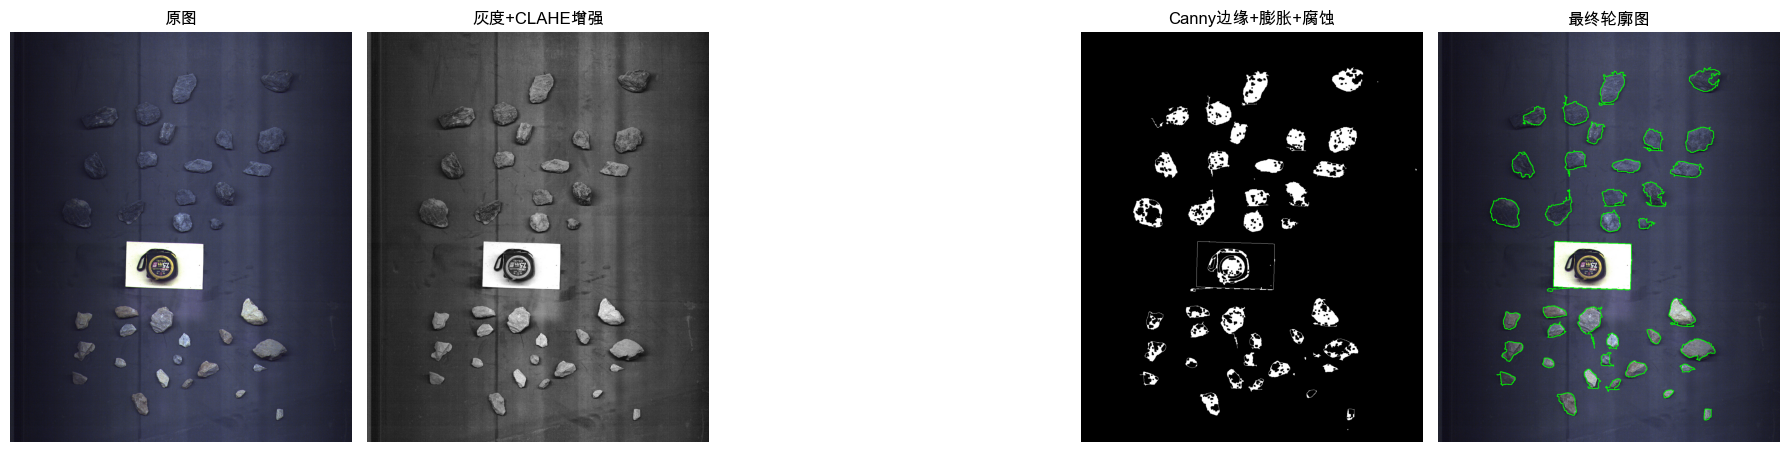

In [192]:
# 转为灰度图

# 高斯模糊（可减少噪点）
blurred = cv2.GaussianBlur(img_gray, (1, 1), 0)

gray = blurred

# CLAHE增强局部对比度
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_enhanced = clahe.apply(gray)

# gray_enhanced = cv2.medianBlur(gray_enhanced, 1)

# Canny边缘检测
edges = cv2.Canny(gray_enhanced, threshold1=50, threshold2=300)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# edges_dilated = cv2.dilate(edges, kernel, iterations=1)
# edges_smoothed = cv2.erode(edges_dilated, kernel, iterations=1)

# 替换 dilate + erode 为 closing（先膨胀再腐蚀，封闭小缝隙）
edges_smoothed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

# 创建一个细长的卷积核（强调去除细长线）
# kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))  # 水平划痕
# opened = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_line)
# 或者垂直方向
# kernel_line_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
# opened_v = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_line_v)
# # 合并结果（保留去除划痕后的图像）
# edges_cleaned = cv2.bitwise_and(edges, cv2.bitwise_not(opened_v))

# 查找所有轮廓
contours, _ = cv2.findContours(edges_smoothed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 设置面积阈值，过滤掉太小的轮廓
min_area = 500  # 可根据图像大小调整
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# 绘制轮廓
contour_img = img.copy()
cv2.drawContours(contour_img, filtered_contours, -1, (0, 255, 0), 2)

# 显示所有中间步骤
plt.figure(figsize=(18, 6))

plt.subplot(1, 5, 1)
plt.title("原图")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title("灰度+CLAHE增强")
plt.imshow(gray_enhanced, cmap='gray')
plt.axis('off')

# plt.subplot(1, 5, 3)
# plt.title("Canny边缘+膨胀")
# plt.imshow(edges_dilated, cmap='gray')
# plt.axis('off')

plt.subplot(1, 5, 4)
plt.title("Canny边缘+膨胀+腐蚀")
plt.imshow(edges_smoothed, cmap='gray')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title("最终轮廓图")
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


In [171]:
len(contours)

271

轮廓总数：86
面积范围：32.0 - 53483.0
平均面积：2905.8
中位数面积：410.8


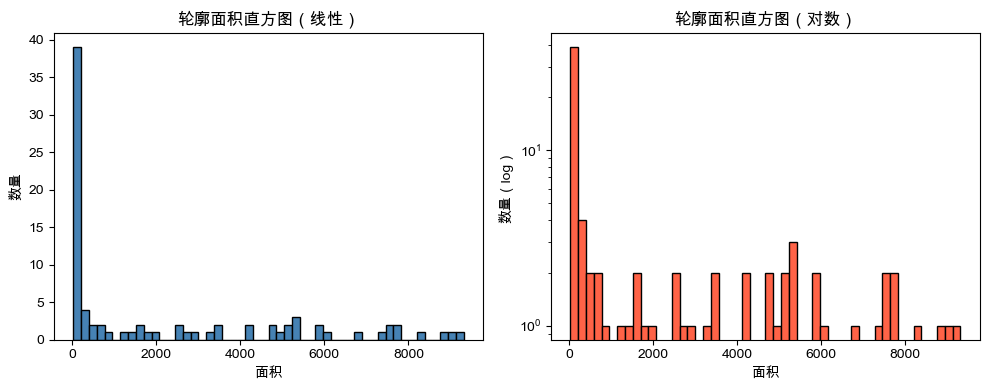

In [88]:
# 计算每个轮廓的面积
areas = [cv2.contourArea(cnt) for cnt in contours]

# 可选：过滤掉太小的值防止干扰直方图可视化
areas_filtered = [a for a in areas if a > 10 and a < 10000]

# 统计信息
print(f"轮廓总数：{len(areas)}")
print(f"面积范围：{min(areas):.1f} - {max(areas):.1f}")
print(f"平均面积：{np.mean(areas):.1f}")
print(f"中位数面积：{np.median(areas):.1f}")

# 绘制面积直方图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(areas_filtered, bins=50, color='steelblue', edgecolor='black')
plt.title("轮廓面积直方图（线性）")
plt.xlabel("面积")
plt.ylabel("数量")

plt.subplot(1, 2, 2)
plt.hist(areas_filtered, bins=50, log=True, color='tomato', edgecolor='black')
plt.title("轮廓面积直方图（对数）")
plt.xlabel("面积")
plt.ylabel("数量（log）")

plt.tight_layout()
plt.show()